In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.applications as app
import keras.layers as kl
import seaborn as sns
import matplotlib.patheffects as PathEffects
import cv2
import os
import mlflow
import mlflow.keras
import imgaug.augmenters as iaa

from tqdm import tqdm as tqdm
from sklearn.metrics import confusion_matrix
from keras.models import Model, Sequential
from keras.optimizers import Adagrad
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from time import time
from sklearn.manifold import TSNE
from mpl_toolkits import mplot3d
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
epoch = 5
m     = 0.9

In [3]:
mnist = tf.keras.datasets.mnist

In [4]:
(x_train, y_train_),(x_test, y_test_) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

few_shot_number = np.sum(y_train_ == 8)
few_shot = random.choice(x_train[y_train_ == 8])
few_shot = np.array(np.sum(y_train_ == 8)*[few_shot])

In [5]:
seq = iaa.Sequential([
    iaa.Crop(px=(0, 3)),
    iaa.Fliplr(0.5),
    iaa.OneOf([iaa.PiecewiseAffine(scale=(0.02, 0.05)), 
               iaa.Affine(shear=(-12, 12))]),
    iaa.Sometimes(0.5, iaa.Affine(rotate=(-10, 10))),
    iaa.Sometimes(0.8, iaa.Affine(scale={"x": (0.7, 1.2), "y": (0.7, 1.2)})),
    iaa.Sometimes(0.7, iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}))
])

In [6]:
few_shot_aug = seq.augment_images(few_shot)

In [7]:
x_train  = x_train[y_train_ != 8]
y_train_ = y_train_[y_train_ != 8]

x_train = np.concatenate([x_train, few_shot_aug])
y_train_ = np.concatenate([y_train_, np.array(few_shot_number*[8])])

x_movie = x_train[:500]
y_movie = y_train_[:500]

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test, (len(x_test), 28, 28, 1))

y_train2 = np.zeros((len(x_train), 10))
for j, i in enumerate(y_train_):
    y_train2[j, i] = 1
    
y_test2 = np.zeros((len(x_test), 10))
for j, i in enumerate(y_test_):
    y_test2[j, i] = 1

In [8]:
def triplet_generation(x, y, sample = 500):
    data = [[] for _ in range(10)]
    triplets = []
    for pair in zip(x, y):
        data[pair[1]].append(pair[0])
    for number in range(10):
        for _ in range(sample):
            negative = list(range(10))
            negative.pop(number)
            negative = random.choice(negative)
            triplet = ([random.choice(data[number]), 
                       random.choice(data[number]), 
                       random.choice(data[negative])], 
                       number)
            triplets.append(triplet)
    return np.array(triplets)

In [9]:
boucles = [0, 2, 6, 9, 8]
def triplet_loss(y_true, y_pred, m = m):
    length = int((y_pred[0].shape[-1]))
    
    y_anchor    = np.array(y_true[:, 0])
    y_negative  = np.array(y_true[:, 1])
    opposite_class  = np.bitwise_xor(np.isin(y_anchor, boucles), np.isin(y_negative, boucles))
    
    anchor_vec   = y_pred[:, :int(length/3)]
    positive_vec = y_pred[:, int(length/3):int(length/1.5)]
    negative_vec = y_pred[:, int(length/1.5):length]
    
    bad  = K.sum(K.square(anchor_vec - positive_vec), axis = 1)
    good = K.sum(K.square(anchor_vec - negative_vec * (1 - 0.5*opposite_class)), axis = 1)

    loss = bad - good + m
    return K.maximum(loss, 0.)

In [10]:
def one_hot(y):
    encodded = np.zeros((len(y), 10))
    for i in range(len(encodded)):
        encodded[i, y[i]] = 1
    return encodded

In [11]:
def get_triplets(model, x_train, y_train):
    embeddings = model.predict(x_train)
    classes = np.argmax(y_train, axis = 1)
    triplet = []
    distances = distance_matrix(embeddings)
    classes_neg = np.ones(y_train.shape) - y_train
    mask_neg = np.dot(y_train, np.transpose(classes_neg))
    distances = distances * mask_neg
    distances[distances == 0] = np.max(distances) + 1
    for i, anchor in enumerate(x_train):
        validate = np.where(classes == classes[i])[0]
        for j in validate:
            k = np.random.choice((-distances[i]).argsort()[-1:][::-1])
            triplet.append((i, j, k))
    return triplet

In [12]:
def distance_matrix(embeddings, squared=False):
    dot_product = np.dot(embeddings, np.transpose(embeddings))
    square_norm = np.diagonal(dot_product)
    distances = np.tile(square_norm, (square_norm.shape[0], 1)) - 2.0 * dot_product + np.transpose(np.tile(square_norm, (square_norm.shape[0], 1)))
    distances[distances < 0.0] = 0.0
    
    if not squared:
        mask = distances == 0.0
        distances = distances + mask * 1e-16
        distances = np.sqrt(distances)
        distances = distances * (1.0 - mask)

    return distances

In [13]:
anchor_input   = kl.Input((28, 28, 1), name = 'anchor_input')
positive_input = kl.Input((28, 28, 1), name = 'positive_input')
negative_input = kl.Input((28, 28, 1), name = 'negative_input')

In [14]:
def base_model():
    model = Sequential()
    model.add(kl.Conv2D(32, 2, input_shape=(28, 28,1), activation='relu', padding='valid'))
    model.add(kl.MaxPooling2D())
    model.add(kl.Conv2D(64, 2, activation='relu', padding='valid'))
    model.add(kl.MaxPooling2D())
    model.add(kl.Flatten())
    model.add(kl.Dense(256, activation = 'relu'))
    model.add(kl.Dropout(0.5))
    model.add(kl.Dense(10))
    model.add(kl.Lambda(lambda t: K.l2_normalize(1000*t, axis=1)))
    
    return model

In [15]:
shared_network = base_model()

C:\Users\Utilisateur\.conda\envs\keelab\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
anchor   = shared_network(anchor_input)
positive = shared_network(positive_input)
negative = shared_network(negative_input)

merged = kl.concatenate([anchor, positive, negative], axis = 1)

model  = Model(inputs = [anchor_input, positive_input, negative_input], outputs = merged)
loaded_model = Model(inputs = anchor_input, outputs = anchor)

In [17]:
opt = Adagrad()

In [18]:
model.compile(optimizer = opt, loss = triplet_loss)


In [ ]:
frame = 0
for _ in tqdm(range(epoch)):
    c = list(zip(x_train, y_train_))
    random.shuffle(c)
    x_train, y_train_ = zip(*c)
    x_train   = np.array(x_train)
    y_train_  = np.array(y_train_)
    for batch in range(0, len(x_train), 32):
        loaded_model.set_weights(model.get_weights())
        anchor    = []
        positive  = []
        negative  = []
        y         = []
        data_x    = x_train[batch: batch+32]
        data_y    = y_train_[batch: batch+32]
        one_hot_y = one_hot(data_y)
        triplets  = get_triplets(loaded_model, data_x, one_hot_y)
        for (i, j, k) in triplets:
            anchor.append(data_x[i])
            positive.append(data_x[j])
            negative.append(data_x[k])
            y.append([data_y[i], data_y[k]])
        y = np.array(y)
        model.fit([anchor, positive, negative], y, batch_size = 32, verbose = 0)
        if not frame % 70:
            x = model.predict(3*[x_movie[:500].reshape(-1,28,28,1)])[:, :3]
            palette = np.array(sns.color_palette("hls", 10))
            fig = plt.figure(figsize=(12, 11))
            ax = fig.add_subplot(2, 2, 1, projection='3d')
            ax.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                                c=palette[np.array(np.isin(y_movie[:500], boucles)).astype(np.int)]);
            ax.set_xlim(-1.5, 1.5)
            ax.set_ylim(-1.5, 1.5)
            ax.set_zlim(-1.5, 1.5)
            axi = fig.add_subplot(2, 2, 2, projection='3d')
            axi.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                                c=palette[np.array(y_movie[:500]).astype(np.int)]);
            axi.set_xlim(-1.5, 1.5)
            axi.set_ylim(-1.5, 1.5)
            axi.set_zlim(-1.5, 1.5)
            fig.savefig('./movie/{}.png'.format(frame//70))
            plt.close(fig)
        frame += 1
    model.save_weights('./few_shot.h5')

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


 60%|████████████████████████████████████████████████                                | 3/5 [1:01:25<40:11, 1205.69s/it]

In [ ]:
data_train = triplet_generation(x_train, y_train_, 3500)
data_test  = triplet_generation(x_test, y_test_, 200)

In [ ]:
anchor_train   = []
positive_train = []
negative_train = []
y_train        = []
np.random.shuffle(data_train)
for data in data_train:
    anchor_train.append(data[0][0])
    positive_train.append(data[0][1])
    negative_train.append(data[0][2])
    y_train.append(data[1])

In [ ]:
anchor_test   = []
positive_test = []
negative_test = []
y_test        = []
np.random.shuffle(data_test)
for data in data_test:
    anchor_test.append(data[0][0])
    positive_test.append(data[0][1])
    negative_test.append(data[0][2])
    y_test.append(data[1])

In [78]:
class LiveAction(Callback):
    def on_train_begin(self, logs={}):
        self.counter = 0
        
    def on_batch_end(self, batch, logs={}):
        self.counter += 1
        if not self.counter % 70:
            x = self.model.predict(3*[x_movie[:500].reshape(-1,28,28,1)])[:, :3]
            palette = np.array(sns.color_palette("hls", 10))
            fig = plt.figure(figsize = (10,10))
            ax  = plt.axes(projection="3d")
            ax.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                                c=palette[np.array(y_movie[:500]).astype(np.int)]);
            ax.set_xlim(-2, 2)
            ax.set_ylim(-2, 2)
            ax.set_zlim(-2, 2)
            fig.savefig('./movie/{}.png'.format(self.counter//70))
            plt.close(fig)

In [79]:
live_action = LiveAction()

In [80]:
hist = model.fit([anchor_train, positive_train, negative_train],
          y               = y_train,
          validation_data = ([anchor_test,positive_test,negative_test], y_test), 
          batch_size      = 128, 
          epochs          = 20, 
          callbacks       = [live_action]
          ) 

mlflow.log_param("Few_shot", 8)
mlflow.log_param("Regularisation", reg)
mlflow.log_param("Activation", activation)
mlflow.log_param("m", m)
mlflow.log_metric("loss", hist.history['loss'][-1])
mlflow.keras.log_model(model, "models")

Train on 35000 samples, validate on 2000 samples
Epoch 1/20
 5888/35000 [====>.........................] - ETA: 2:21 - loss: 0.3891

KeyboardInterrupt: 

In [21]:
model.save_weights('./poid_ter')

In [24]:
new_model = Model(inputs = anchor_input, outputs = anchor)
new_model.load_weights('./poid_ter')

In [25]:
x = new_model.predict(x_test.reshape(-1,28,28,1))

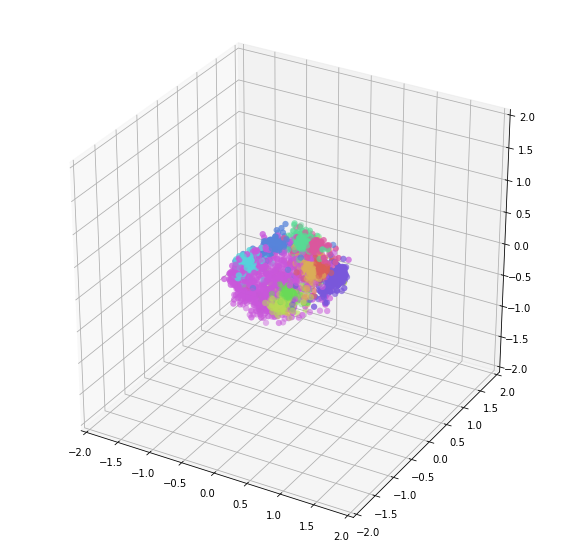

In [26]:
palette = np.array(sns.color_palette("hls", 10))
fig = plt.figure(figsize = (10,10))
ax  = plt.axes(projection="3d")
ax.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                    c=palette[np.array(y_test_).astype(np.int)]);
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)
fig.savefig('')

In [27]:
x = new_model(anchor_input)
x = kl.Dense(2, activation = 'softmax')(x)

In [28]:
model_classifier = Model(inputs = anchor_input, output = x)

C:\Users\Utilisateur\.conda\envs\keelab\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("an..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [29]:
y_train3 = [int(i in boucles) for i in y_train_]
y_test3  = [int(i in boucles) for i in y_test_]

In [30]:
y_train3 = one_hot(y_train3)[:, :2]
y_test3  = one_hot(y_test3)[:, :2]

In [31]:
y_test3[111]

array([1., 0.])

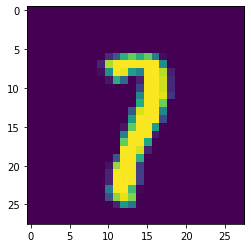

In [32]:
plt.imshow(np.reshape(x_test[111], (28, 28)))

In [33]:
for l in model_classifier.layers[:-1]:
    l.trainable = False

In [34]:
opt = Adagrad()

In [35]:
model_classifier.compile(loss      = "categorical_crossentropy", 
              optimizer = opt,
              metrics   = ["accuracy"])

In [36]:
hist = model_classifier.fit(x_train,
          y               = y_train3,
          validation_data = (x_test, y_test3), 
          batch_size      = 128, 
          epochs          = 10
          ) 

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - ETA: 9:15 - loss: 0.8089 - acc: 0.414 - ETA: 6:00 - loss: 0.7994 - acc: 0.437 - ETA: 4:41 - loss: 0.8012 - acc: 0.411 - ETA: 3:55 - loss: 0.7804 - acc: 0.431 - ETA: 3:25 - loss: 0.7738 - acc: 0.435 - ETA: 3:05 - loss: 0.7677 - acc: 0.441 - ETA: 2:54 - loss: 0.7588 - acc: 0.455 - ETA: 2:47 - loss: 0.7574 - acc: 0.461 - ETA: 2:38 - loss: 0.7508 - acc: 0.466 - ETA: 2:30 - loss: 0.7481 - acc: 0.466 - ETA: 2:25 - loss: 0.7485 - acc: 0.466 - ETA: 2:22 - loss: 0.7464 - acc: 0.468 - ETA: 2:22 - loss: 0.7422 - acc: 0.476 - ETA: 2:18 - loss: 0.7372 - acc: 0.481 - ETA: 2:13 - loss: 0.7365 - acc: 0.483 - ETA: 2:09 - loss: 0.7333 - acc: 0.488 - ETA: 2:08 - loss: 0.7315 - acc: 0.489 - ETA: 2:06 - loss: 0.7334 - acc: 0.487 - ETA: 2:07 - loss: 0.7346 - acc: 0.483 - ETA: 2:04 - loss: 0.7308 - acc: 0.489 - ETA: 2:01 - loss: 0.7305 - acc: 0.489 - ETA: 1:59 - loss: 0.7308 - acc: 0.489 - ETA: 1:57 - 

In [37]:
y_pred = model_classifier.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)

In [38]:
matrix = confusion_matrix(y_test_,
                          y_pred,
                          labels = [i for i in range(10)])

In [39]:
matrix[:, :2]

array([[   1,  979],
       [1135,    0],
       [  11, 1021],
       [1010,    0],
       [ 968,   14],
       [ 887,    5],
       [   7,  951],
       [1016,   12],
       [ 357,  617],
       [  21,  988]], dtype=int64)